### Classification with Pre-Trained ViT base model

In order to reduce time, only a subset of the dataset is used here for training. The images are also cropped to ensure it is compatible with the pre-trained model.

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['notflip','flip']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\saaji/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|███████████████████████████████████████████████████████████████████████████████| 330M/330M [00:25<00:00, 13.7MB/s]


In [6]:
from torchinfo import summary

# Print model summary
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [7]:
# Setup directory paths to train and test images
train_dir = 'subset/training'
test_dir = 'subset/testing'

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


The transforms are ready, now our images can be taken using DataLoaders.

In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) 


In [12]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5158 | train_acc: 0.7828 | test_loss: 0.5520 | test_acc: 0.7352
Epoch: 2 | train_loss: 0.3045 | train_acc: 0.9203 | test_loss: 0.5198 | test_acc: 0.7722
Epoch: 3 | train_loss: 0.2300 | train_acc: 0.9453 | test_loss: 0.5846 | test_acc: 0.7631
Epoch: 4 | train_loss: 0.1968 | train_acc: 0.9510 | test_loss: 0.6544 | test_acc: 0.7568
Epoch: 5 | train_loss: 0.1643 | train_acc: 0.9630 | test_loss: 0.6916 | test_acc: 0.7568
Epoch: 6 | train_loss: 0.1456 | train_acc: 0.9724 | test_loss: 0.6121 | test_acc: 0.8097
Epoch: 7 | train_loss: 0.1273 | train_acc: 0.9750 | test_loss: 0.7075 | test_acc: 0.7756
Epoch: 8 | train_loss: 0.1246 | train_acc: 0.9766 | test_loss: 0.6701 | test_acc: 0.7972
Epoch: 9 | train_loss: 0.1103 | train_acc: 0.9781 | test_loss: 0.6509 | test_acc: 0.8097
Epoch: 10 | train_loss: 0.1020 | train_acc: 0.9766 | test_loss: 0.7395 | test_acc: 0.7881


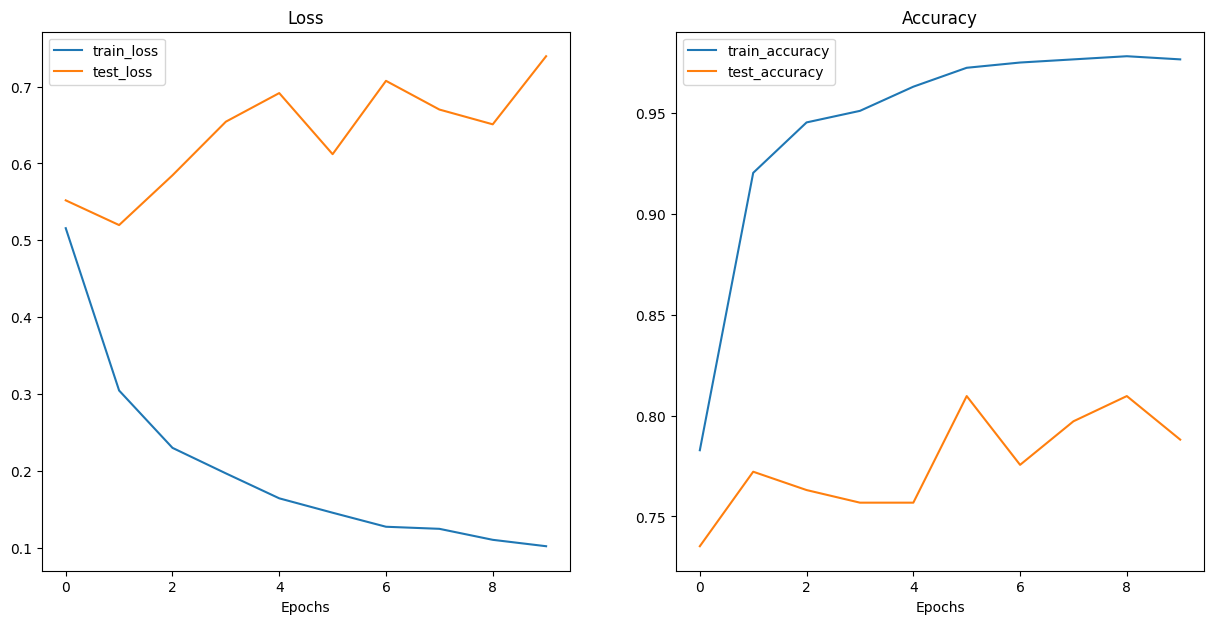

In [13]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

### Prediction:

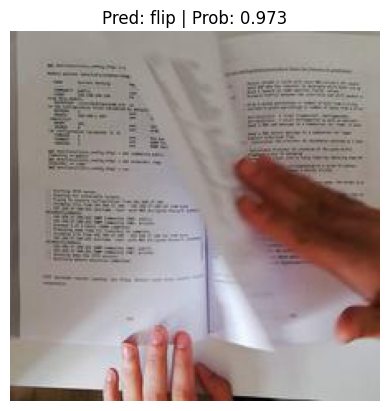

In [14]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "flip_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

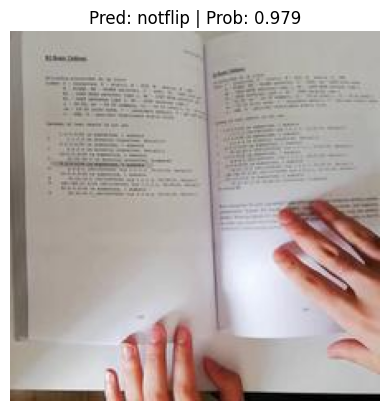

In [17]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "not_flip1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)